> For discrete, contractional business settings where it is easiest to calculate CLV.

In [56]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import scipy.special as sc
import os
from IPython.display import display, Image
import plotly.graph_objs as go
from sBG import compute_probabilities, log_likelihood, maximize, forecast

## Example in Lecture 6 Slide Deck

Assumptions
- Each contact is annual (starting 1/1 and ending 12/31)
- An average net cashflow of 100 dollars a year
- 10% annual discount rate

In [2]:
df = pd.read_csv('../data/sBG-1.csv')

In [3]:
data = (df.loc[0:3, 'Regular'] / 1000).to_list()
data

[0.631, 0.468, 0.382, 0.326]

In [5]:
gamma, delta = maximize(data)
gamma, delta

(0.7636650665025251, 1.2958302797888772)

> **gamma** and **delta** of $0.76$ and $1.29$

In [6]:
# Expectation
gamma / (gamma + delta)

0.3708020354975216

In [9]:
predictions = forecast(data, 12)

In [10]:
df.head()

,Year,Regular,Regular % Alive,Highend,Highend % Alive
0,1,631,0.631,869,0.869
1,2,468,0.468,743,0.743
2,3,382,0.382,653,0.653
3,4,326,0.326,593,0.593
4,5,289,0.289,551,0.551


## Model Fit

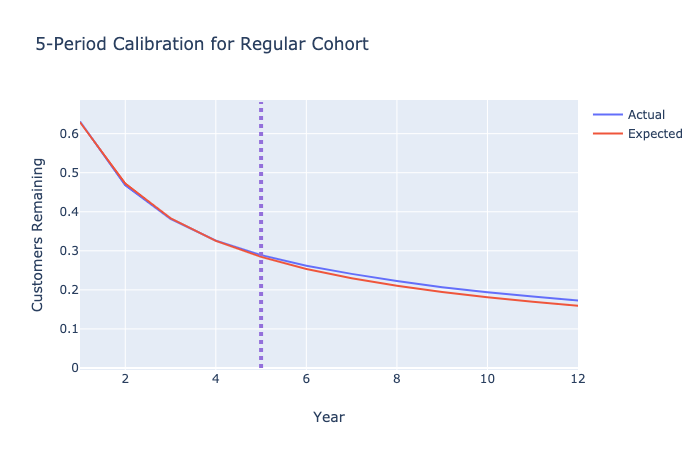

In [17]:
Image('../images/discrete-contractional-figure-1.png')

> Customers in this cohort are living longer than the model suggests. This seems to imply negative duration dependence in this context as the longer these customers stay, the probability of them dying seems to go down.

## DEL 

There are two ways to calculate the DEL (Discounted Expected Lifetime):

### Easy Way

The equation on slide 64 is $$DEL = \sum_{t=0}^\infty \frac{S(t)}{(1+d)^t}$$

where $S(t)$ is the proportion of survival at time $t$ (what \% of people are alive at time $t$) , and $d$ is the discount rate per year (assume to be constant as well).

In [62]:
discount_rate = 0.1
cashflow = 100

In [91]:
def DEL(data, discount_rate):
    '''Function that takes in discrete time survival data, fits
    a sBG and calculates the discounted expected lifetime for 1000 periods'''
    survival = [1.0] + forecast(data, 999).to_list()
    discount = []
    for t in range(1000):
        discount.append(1 / (1+discount_rate)**t)
        
    return np.sum(np.array(survival) * np.array(discount))

In [92]:
DEL(data, discount_rate)

3.6211477487193413

### Hard Way

> See notes.

The resulting formula is a Gaussian Hypergeometric function $$_2F_{1}(1, \delta, \gamma + \delta, \frac{1}{})$$

In [68]:
result_del = sc.hyp2f1(1, delta, gamma + delta, 1 / (1+discount_rate))
result_del

3.621147748719336

> Probably the more elegant way to code this

## CLV

$$E[CLV] = \sum_{t=0}^\infty \frac{v_{t} \cdot S(t)}{(1+d)^t} = v_{t} \times DEL$$

In [69]:
result_del * cashflow

362.1147748719336

## DERL

The Discounted Expected Residual Lifetime. For instance, if we are at the end of Year $n$, what is the expected residual lifetime value of an alive customer?

For the BG model, $$DERL(\gamma, \delta, d, n - 1) = \sum_{t = n}^{\infty} \frac{S(t | \gamma, \delta) / S(n-1 | \gamma, \delta)}{(1+d)^t}$$

### Easy Way

In [105]:
def DERL1(data, discount_rate, n):
    '''Calculates the discounted expected residual lifetime which is the expected lifetime
    given a customer has been alive for n periods or has done n-1 renewals'''
    survival = [1.0] + forecast(data, 999).to_list()
    sliced_survival = np.array(survival[n:])
    
    # Compute conditional surival array S(t|t > n-1)
    cond_survival = []
    for i in range(1000-n):
        cond_survival.append(sliced_survival[i]/survival[n-1])
        
    # Compute discount array
    discount = []
    for t in range(1000-n):
        discount.append(1 / (1+discount_rate)**t)
    
    return np.sum(np.array(cond_survival) * np.array(discount))

In [106]:
# DERL for customer who has survived 5 periods (renewed 4 times) - Slide 71 Lecture 6
DERL1(data, discount_rate, 5)

5.68381020594769

> In other words, if we were to project ahead what is the probability of a customer staying with us for 5, 10, 20 more years (residual years), the average number of renewals a customer would make given that they have already renewed 4 times/survived 5 periods is $5.68$.

### Hard Way

> See notes.

Resulting formula also follows a Gaussian Hypergeometric Distribution but we also have to add on a bayesian element we get from deriving the posterior distribution from the conditional.

In [108]:
def DERL2(data, discount, n):
    gamma, delta = maximize(data)
    return (delta+n-1)/(gamma+delta+n-1) * sc.hyp2f1(1, delta+n, gamma+delta+n, 1 / (1+discount_rate))

In [109]:
DERL2(data, discount_rate, 5)

5.683810205947677

> Also the cleaner way to do this compared to using for loop and capping at $t=1000$

### Visualizing DERL for varying n

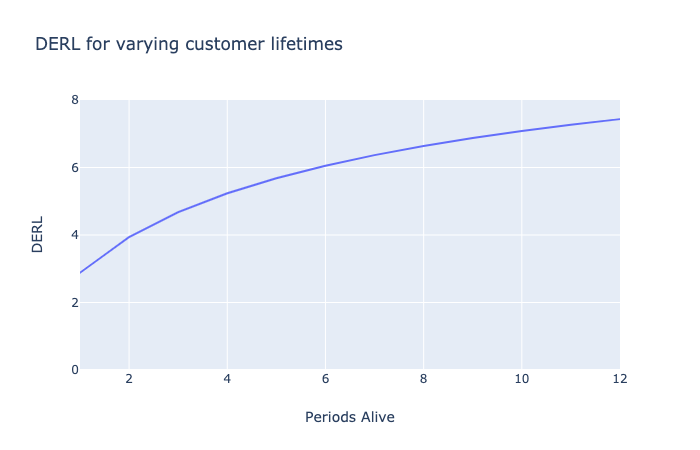

In [121]:
Image('../images/discrete-contractional-figure-2.png')

> If we want to include duration dependence into the model, we can use the Beta-discrete Weibull. However, I'm too lazy to implement that right now.